# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=30"

In [2]:
import requests
import bs4 as soup
from bs4 import BeautifulSoup
from IPython.core.display import HTML, Image
import pandas as pd

In [3]:
# use requests to call hte url
r = requests.get(URL)

In [4]:
# test request
r.request.headers

for k, v in r.request.headers.items():
    print(k + ':', v)
    
HTML(r.content.decode('utf-8'))

('Connection:', 'keep-alive')
('Cookie:', 'BIGipServerjob_iad=!SQMfeSnQTnm4le0RNhs+rOzpOInz89nteEZuP1hGkQZP+1VPCCv99sq87Vns+fTESxi7S94tiJbGVeI=; INDEED_CSRF_TOKEN=ahu9lHcIlUQyKYLlN6tTgk6VPQRaPTTc; ctkgen=1; JSESSIONID=2748AFBAAFAE20BE392D642D43597DDF.jasxA_iad-job19; CTK=1an39567t5un6biu')
('Accept-Encoding:', 'gzip, deflate')
('Accept:', '*/*')
('User-Agent:', 'python-requests/2.9.1')


In [5]:
# test printing out the title 
soup = BeautifulSoup(r.content)
soup.title.text

# test to call company names
for x in soup.findAll('span', class_ = 'company'):
    print x.text



    Gallup

    New York University College of Dentistry



    MLB Advanced Media




    Empiric Solutions




    Rensselaer Polytechnic Institute




    Amazon Corporate LLC




    Google




    Etsy




    JPMorgan Chase




    AIG




    Verizon




    Columbia University


    AbilTo, Inc


    Chegg


    UncommonGoods


/Users/Lydia/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [2]:
# read needed info into dataframe
df = pd.DataFrame()
city = ['New+York', 'Chicago', 'San+Francisco', 'Austin','Philadelphia','Houston','Los+Angeles','DC','Boston','Las+Vegas']
for c in city:
    # there are only 100 pages of results available
    for p in range(1,100): 
        url = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l='
        r = requests.get(url + c+'&start=' + str(p*10))
        soup = BeautifulSoup(r.content, "lxml")
        # check status
        if p == 10:
            print p
        for x in soup.findAll('div', {'class' : ' row result'}):
            try:
                company = x.find('span', {'itemprop':'name'}).getText().strip() # company name 
                title = x.find('a', {'itemprop':'title'}).getText().strip() # job title
                location = x.find('span', {'itemprop':'addressLocality'}).getText().strip() # location
                description = x.find('span', {'itemprop':'description'}).getText().strip() # abbreviated description
                date = x.find('span', {'class':'date'}).getText().strip()
                salary = x.find('nobr')
                df = df.append({'company': company, 'title': title, 'post_date': date, 'location': location, 'description': description, 'salary':salary}, ignore_index=True)
            except:
                pass

10
10
10
10
10
10
10
10
10
10


In [259]:
# check rows we received with salary info 
df.info()
sum(df.salary.value_counts())

927

In [7]:
# new dataframe with any cities, fulltime job only
ft = pd.DataFrame()

for p in range(1,100): 
    url = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&jt=fulltime&start='
    r = requests.get(url + str(p*10))
    soup = BeautifulSoup(r.content, 'lxml')
    if p == 10:
            print p
    for x in soup.findAll('div', {'class' : ' row result'}):
        try:
            company = x.find('span', {'itemprop':'name'}).getText().strip() # company name 
            title = x.find('a', {'itemprop':'title'}).getText().strip() # job title
            location = x.find('span', {'itemprop':'addressLocality'}).getText().strip() # location
            description = x.find('span', {'itemprop':'description'}).getText().strip() # abbreviated description
            date = x.find('span', {'class':'date'}).getText().strip()
            salary = x.find('nobr')
            ft = ft.append({'company': company, 'title': title, 'post_date': date, 'location': location, 'description': description, 'salary':salary}, ignore_index=True)
        except:
            pass

10


In [260]:
# check the info for the full time dataframe
ft.info()

AttributeError: 'Series' object has no attribute 'info'

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [26]:
YOUR_CITY = ''

In [27]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        # Append to the full set of results
        pass

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [28]:
## YOUR CODE HERE

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [29]:
## YOUR CODE HERE


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [30]:
## YOUR CODE HERE

# Cleaning data!

In [9]:
import numpy as np
# creating temp columns to split up the addresses in to city and states
ft['temp'] = [x.split(',') for x in ft.location]

# assign cities into a new column
ft['city'] = [x[0] for x in ft.temp] 
ft['temp1'] = [x[1:] for x in ft.temp] 

# assign states into a new column
states = []
for x in ft.temp1:
    try: 
        states.append(str(x)[4] + str(x)[5]) 
    except: 
        states.append(np.nan)
ft['state'] = states

In [15]:
# check out suspecious looking cities
print ft.city.unique()
ft.city.value_counts()
temp = ft.ix[(ft['city'] == 'United States') | (ft['city'] =='Job') | (ft['city'] == 'Remote') | (ft['city'] =='New Jersey')]
temp

[u'Hillsboro' nan u'Chicago' u'Bethesda' u'Mountain View' u'Madison'
 u'Houston' u'Dearborn' u'Philadelphia' u'Ashburn' u'New York' u'Boise'
 u'Basking Ridge' u'Yaphank' u'Springfield' u'Brooklyn' u'Dayton'
 u'San Diego' u'Menlo Park' u'San Francisco' u'Buffalo' u'San Bruno'
 u'Lowell' u'Pittsburgh' u'Summit' u'Atlanta' u'Norwood' u'Rahway'
 u'Waltham' u'Washington' u'Eden Prairie' u'Schriever AFB' u'Wilmington'
 u'North Reading' u'Phoenix' u'Framingham' u'Huntsville' u'Ann Arbor'
 u'Pleasanton' u'Frisco' u'Louisville' u'Iowa City' u'Hyattsville'
 u'Indianapolis' u'Mount View' u'Rockwall' u'Newark' u'Santa Barbara'
 u'Gaithersburg' u'Huntington Beach' u'Emeryville' u'Scottsdale'
 u'Golden Valley' u'Bentonville' u'Woodinville' u'Columbus' u'Middlebury'
 u'Charlotte' u'Tampa' u'Elkhart Lake' u'Baltimore' u'Palo Alto'
 u'Colorado Springs' u'Greenfield' u'Tempe' u'Fort Lauderdale' u'Middleton'
 u'Draper' u'Oregon' u'Schenectady' u'Chelmsford' u'Wisconsin'
 u'Burlington' u'Research Triangle

In [13]:
# get rid off wrong city
ft.city.replace('Remote',np.nan, inplace =True)    
ft.city.replace('Job',np.nan, inplace =True) 
ft.city.replace('United States',np.nan, inplace =True) 

# Reassign city 'New Jersey' to state
ft.state[ft['city'] == 'New Jersey'] = 'NJ'
ft.city[ft['city'] == 'New Jersey'] = np.nan
# check if it's been reassigned
ft[ft['company'] == 'J & J Consumer Inc.']

,company,description,location,post_date,salary,title,temp,city,temp1,state
421,J & J Consumer Inc.,The Senior Scientist will:. The Senior Scienti...,New Jersey,30+ days ago,None,"Senior Scientist, Data Sciences",[New Jersey],NaN,[],NJ


In [14]:
# check state column 
ft.state.value_counts()

NY    165
CA    146
MD     47
MA     38
PA     37
IL     36
TX     36
VA     35
NJ     35
WA     28
FL     26
NC     22
GA     19
MO     17
MI     17
DC     14
MN     12
CO     12
CT     11
AZ     11
OH     10
UT     10
WI      9
DE      7
NM      6
OK      6
SC      6
IN      5
TN      5
OR      5
AL      4
KY      4
KS      4
NH      4
IA      4
ME      3
AR      3
HI      3
NE      2
VT      2
NV      2
SD      2
LA      1
ID      1
WY      1
MT      1
RI      1
Name: state, dtype: int64

In [16]:
# drop the temp columns 
ft = ft.drop(['temp','temp1'], axis = 1)

In [17]:
# check salary info
ft.salary.value_counts()

<nobr>$120,000 a year</nobr>               4
<nobr>$150,000 a year</nobr>               4
<nobr>$200,000 a year</nobr>               3
<nobr>$80,000 - $100,000 a year</nobr>     3
<nobr>$130,000 a year</nobr>               2
<nobr>$85,000 a year</nobr>                2
<nobr>$125,000 a year</nobr>               2
<nobr>$48,000 a year</nobr>                2
<nobr>$81,878 - $121,525 a year</nobr>     2
<nobr>$125,000 - $145,000 a year</nobr>    2
<nobr>$68,239 - $85,644 a year</nobr>      2
<nobr>$90,000 a year</nobr>                2
<nobr>$60,000 a year</nobr>                2
<nobr>$50,000 a year</nobr>                2
<nobr>$5,875 - $9,400 a month</nobr>       1
<nobr>$75,000 a year</nobr>                1
<nobr>$100,000 a year</nobr>               1
<nobr>$48,200 - $74,400 a year</nobr>      1
<nobr>$4,742 - $8,533 a month</nobr>       1
<nobr>$120,000 - $160,000 a year</nobr>    1
<nobr>$80,000 - $200,000 a year</nobr>     1
<nobr>$150,000 - $300,000 a year</nobr>    1
<nobr>$53,

In [18]:
# change salary to string 
def to_string(x):
    try:
        y = str(x)
        return y
    except:
        pass  

ft.salary = ft.salary.apply(to_string)

# check data type 
type(ft.salary[16])

str

In [19]:
# create new columns for different types of salary
ft.loc[ft.salary.str.contains('year'), 'yearly_salary'] = ft['salary']
ft.loc[ft.salary.str.contains('month'), 'monthly_salary'] = ft['salary']

In [21]:
# seperating yearly salary column 
for x in ft.yearly_salary: 
    try:
        print x
        print x.split()
        print x.split()[0]
        print x.split()[2]
        print ''
    except:
        pass

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$125,000 a year</nobr>
['<nobr>$125,000', 'a', 'year</nobr>']
<nobr>$125,000
year</nobr>

nan
nan
nan
<nobr>$185,000 a year</nobr>
['<nobr>$185,000', 'a', 'year</nobr>']
<nobr>$185,000
year</nobr>

nan
nan
nan
<nobr>$120,000 a year</nobr>
['<nobr>$120,000', 'a', 'year</nobr>']
<nobr>$120,000
year</nobr>

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$170,000 - $200,000 a year</nobr>
['<nobr>$170,000', '-', '$200,000', 'a', 'year</nobr>']
<nobr>$170,000
$200,000

nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$110,000 a year</nobr>
['<nobr>$110,000', 'a', 'year</nobr>']
<nobr>$110,000
year</nobr>

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$90,000 a year</nobr>
['<nobr>$90,000', 'a', 'year</nobr>']
<nobr>$90,000
year</nobr>

<nobr>$75,000 a year</nobr>
['<nobr>$75,000', 'a', 'year</nobr>']
<nobr>$75,000
year</nobr>

nan
<nobr>$77,490 - $100,736 

In [22]:
# create new column for high and low range/ rewrite the seperate range into different columns 
range_l = []
range_h = []
for x in ft['yearly_salary']: 
    try:
        range_l.append(x.split()[0])
        range_h.append(x.split()[2])
    except:
        range_l.append(np.nan)
        range_h.append(np.nan)
ft['range_low'] = range_l
ft['range_high'] = range_h
ft

,company,description,location,post_date,salary,title,city,state,yearly_salary,monthly_salary,range_low,range_high
0,Intel,Test and data build artifact distribution; Int...,"Hillsboro, OR 97124",2 days ago,None,Devops and Automation System Engineer,Hillsboro,OR,NaN,NaN,NaN,NaN
1,"GENEWIZ, Inc.",Hands on Next-generation sequencing and data a...,New Jersey,3 days ago,None,"Scientist I, Research and Development",NaN,NJ,NaN,NaN,NaN,NaN
2,Kaplan,Metis Senior Data Scientists provide incredibl...,"Chicago, IL",26 days ago,None,Senior Data Scientist,Chicago,IL,NaN,NaN,NaN,NaN
3,xometry,Xometry is seeking a senior data scientist to ...,"Bethesda, MD",3 days ago,None,Senior Data Scientist,Bethesda,MD,NaN,NaN,NaN,NaN
4,Google,"As a Data Scientist, you should be experienced...","Mountain View, CA",5 days ago,None,"Data Scientist / Quantitative Analyst, YouTube",Mountain View,CA,NaN,NaN,NaN,NaN
5,American Family Insurance,R433 Statistical Research Scientist (Open). Ex...,"Madison, WI",12 days ago,None,Statistical Research Scientist,Madison,WI,NaN,NaN,NaN,NaN
6,"GeoControl Systems, Inc.","Data collection, reduction and analysis. Exper...","Houston, TX",11 days ago,None,Research Scientist,Houston,TX,NaN,NaN,NaN,NaN
7,"Miracle Software Systems, Inc.",233064-Data Scientists Modeling*. Demonstrated...,"Dearborn, MI",2 days ago,None,Data Scientists Modeling,Dearborn,MI,NaN,NaN,NaN,NaN
8,Reed Elsevier,Text and data mining. Bring active experience ...,"Philadelphia, PA",9 days ago,None,Junior Data Scientist,Philadelphia,PA,NaN,NaN,NaN,NaN
9,Verizon,Data Analytics – Junior Data Scientist. As Wik...,"Ashburn, VA 20147",3 days ago,None,Junior Data Scientist - Data Analytics,Ashburn,VA,NaN,NaN,NaN,NaN


In [23]:
# clean up range low 
def clean_h(x):
    try: 
        y = x.replace('$','')
        z = y.replace(',','')
        return z
    except: 
        pass
ft['range_high']= ft['range_high'].apply(clean_h)
ft['range_high'].replace('year</nobr>',np.nan, inplace =True)    

In [24]:
ft['range_high'].value_counts()

100000    4
200000    3
160000    3
145000    3
180000    2
300000    2
121525    2
120000    2
100736    2
85644     2
50000     1
165000    1
119794    1
130000    1
98000     1
85000     1
58056     1
73935     1
230000    1
91166     1
64070     1
109800    1
90000     1
143229    1
67374     1
45000     1
110000    1
57657     1
65000     1
175000    1
170000    1
114802    1
80400     1
76266     1
49000     1
141555    1
155000    1
139457    1
84141     1
55060     1
69160     1
54000     1
74400     1
48000     1
60000     1
78676     1
112718    1
91952     1
55000     1
150000    1
Name: range_high, dtype: int64

In [26]:
# clean up range low 
def clean_l(x):
    try: 
        y = x.replace('<nobr>$','')
        z = y.replace(',','')
        return z
    except: 
        pass
ft['range_low'] = ft['range_low'].apply(clean_l)
ft['range_low'].value_counts()

80000     7
150000    6
120000    6
100000    6
125000    5
90000     4
110000    4
50000     4
200000    4
48000     2
68239     2
92145     2
130000    2
60000     2
40000     2
55000     2
85000     2
81878     2
115000    2
32900     1
60520     1
42168     1
45219     1
185000    1
103000    1
45000     1
165000    1
53600     1
77490     1
44000     1
         ..
107272    1
86703     1
50648     1
48977     1
42789     1
74260     1
76000     1
46305     1
53448     1
33770     1
75000     1
170000    1
43000     1
89523     1
53435     1
59404     1
61761     1
84458     1
160000    1
65993     1
35595     1
190000    1
48200     1
53206     1
39960     1
108777    1
180000    1
53875     1
42598     1
145000    1
Name: range_low, dtype: int64

In [58]:
# change datatype range into float
ft['range_low'] = ft['range_low'].astype(float)
ft['range_high'] = ft['range_high'].astype(float)
# create a column for the average salary 
ft['salary_avg'] = ft[["range_low", "range_high"]].mean(axis=1)
ft.salary_avg.value_counts()

150000.0    6
90000.0     5
135000.0    4
120000.0    4
130000.0    3
60000.0     3
200000.0    3
50000.0     3
95000.0     2
85000.0     2
125000.0    2
145000.0    2
100000.0    2
185000.0    2
110000.0    2
140000.0    2
190000.0    2
127500.0    2
76941.5     2
101701.5    2
48000.0     2
46000.0     2
53448.0     1
46305.0     1
250000.0    1
165000.0    1
108777.0    1
32900.0     1
51438.0     1
69598.0     1
           ..
105969.5    1
76856.5     1
75000.0     1
67000.0     1
137500.0    1
115000.0    1
45000.0     1
50112.0     1
52000.0     1
61300.0     1
97129.0     1
72500.0     1
180000.0    1
61183.0     1
225000.0    1
55000.0     1
116376.0    1
53875.0     1
42598.0     1
103000.0    1
82500.0     1
75285.0     1
42500.0     1
50648.0     1
87000.0     1
132500.0    1
44415.0     1
94531.0     1
75067.0     1
123364.5    1
Name: salary_avg, dtype: int64

In [81]:
## clean up posted date
# change into string
ft.post_date = ft.post_date.apply(to_string)

In [308]:
# change the time within a day into 1 day
ft.loc[ft.post_date.str.contains('hours'), 'post_date'] = 1
ft.loc[ft.post_date.str.contains('hour'), 'post_date'] = 1
ft.loc[ft.post_date.str.contains('minutes'), 'post_date'] = 1

AttributeError: 'Series' object has no attribute 'post_date'

In [309]:
ft['post_date'] = ft['post_date'].astype(int)

KeyError: 'post_date'

In [317]:
# get rid of the text part 
def clean_d(x): 
    try: 
        y = x.replace(' days ago','')
        y = x.replace(' day ago','')
        y = x.replace('+','')
        return y 
    except: 
        pass
ft['post_date'] = ft['post_date'].apply(clean_d)
ft.post_date.value_counts()

KeyError: 'post_date'

In [99]:
# drop extra columns 
ft = ft.drop(['salary', 'monthly_salary', 'yearly_salary','location'], axis=1)

In [112]:
# save this dataframe to csv
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
# write to file 
ft.to_csv('final_ft.csv')

In [113]:
# do some simple analysis
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

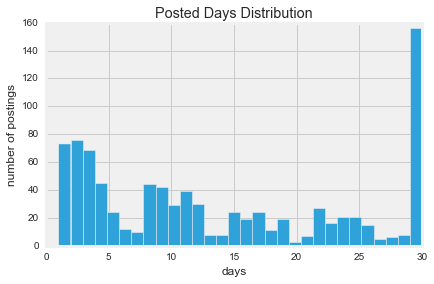

In [151]:
ft['post_date'].hist(bins =30)
plt.title('Posted Days Distribution')
plt.xlabel('days')
plt.ylabel('number of postings')

In [258]:
ft.ix[:, ft.columns.difference(['post_date'])].boxplot()
plt.ylabel('dollar')
plt.title('Salary Boxplot')

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
xticks=temp_state
x=temp_title
y=temp_
pl.plot(x,y)
pl.xticks(x,xticks)
pl.show()

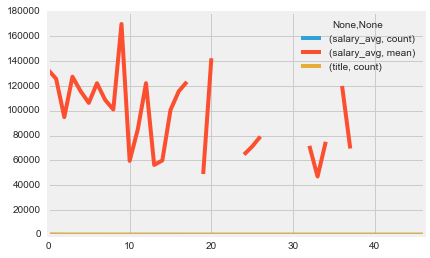

In [247]:
temp_state.plot()

In [1]:
temp_state = pd.pivot_table(ft, index=['state'], aggfunc = {'salary_avg':(np.mean, 'count'), 'title':'count'}).sort_values(by=('title','count'), ascending=False)                                                                                               

NameError: name 'pd' is not defined

In [251]:
pd.pivot_table(ft, index=['state'], aggfunc = {'salary_avg':(np.mean, 'count'), 'title':'count'}).sort_values(by=('title','count'), ascending=False)                                                                                               

AttributeError: 'Series' object has no attribute 'columns'

In [253]:
temp_state.reset_index(inplace=True)
temp_state

index state salary_avg                title
                    count           mean count
0      0    NY         17  133250.470588   165
1      1    CA         12  125833.333333   146
2      2    MD          5   94880.100000    47
3      3    MA          1  127500.000000    38
4      4    PA          6  115816.583333    37
5      5    TX          5  106400.000000    36
6      6    IL          6  122216.666667    36
7      7    NJ          1  108777.000000    35
8      8    VA          6  101048.500000    35
9      9    WA          2  170000.000000    28
10    10    FL          4   59637.000000    26
11    11    NC          4   85131.875000    22
12    12    GA          2  122265.500000    19
13    13    MO          2   56310.500000    17
14    14    MI          1   60000.000000    17
15    15    DC          5  100661.600000    14
16    16    MN          3  115618.833333    12
17    17    CO          1  123364.500000    12
18    18    CT          0            NaN    11
19    19    AZ          2   49000.000000    11
20    20    OH          2  142355.250000    10
21    21    UT          0            NaN    10
22    22    WI          1  147500.000000     9
23    23    DE          0            NaN     7
24    24    SC          2   64723.750000     6
25    25    OK          2   71250.000000     6
26    26    NM          2   79214.500000     6
27    27    TN          0            NaN     5
28    28    OR          0            NaN     5
29    29    IN          0            NaN     5
30    30    AL          0            NaN     4
31    31    NH          0            NaN     4
32    32    KY          2   71724.000000     4
33    33    KS          2   47000.000000     4
34    34    IA          1   75000.000000     4
35    35    AR          0            NaN     3
36    36    ME          1  120000.000000     3
37    37    HI          1   69598.000000     3
38    38    NV          0            NaN     2
39    39    NE          0            NaN     2
40    40    SD          0            NaN     2
41    41    VT          1   46305.000000     2
42    42    MT          0            NaN     1
43    43    RI          0            NaN     1
44    44    LA          0            NaN     1
45    45    ID          0            NaN     1
46    46    WY          1   45000.000000     1

In [256]:
# label = [temp_state.state]
# plt.bar(temp_state.state, temp_state.title)

In [257]:
sum(ft.salary_avg.value_counts())

AttributeError: 'Series' object has no attribute 'salary_avg'

## Clean DF

In [285]:
df.info()

In [270]:
sum(df.salary.value_counts())

927

In [281]:
import numpy as np

# creating temp columns to split up the addresses in to city and states
df['temp'] = [x.split(',') for x in df.location]

# assign cities into a new column
df['city'] = [x[0] for x in df.temp] 
df['temp1'] = [x[1:] for x in df.temp] 

# assign states into a new column
states = []
for x in df.temp1:
    try: 
        states.append(str(x)[4] + str(x)[5]) 
    except: 
        states.append(np.nan)
df['state'] = states

In [276]:
# check out suspecious looking cities
df.city.unique()
df.city.value_counts()
temp = df.ix[(df['city'] == 'United States') | (df['city'] =='Job') | (df['city'] == 'Remote') | (df['city'] =='New Jersey')]
temp

,company,description,location,post_date,salary,title,temp,city,temp1,state


In [288]:
# check state column 
df.state.value_counts()

CA    1761
TX    1533
NV     891
MA     890
NY     884
PA     693
IL     619
VA     353
MD     298
DC     240
DE     103
NJ      11
IN       2
Name: state, dtype: int64

In [289]:
# change salary to string 
def to_string(x):
    try:
        y = str(x)
        return y
    except:
        pass  

df.salary = df.salary.apply(to_string)

# check data type 
type(df.salary[16])

str

In [290]:
# create new columns for different types of salary
df.loc[df.salary.str.contains('year'), 'yearly_salary'] = df['salary']
df.loc[df.salary.str.contains('month'), 'monthly_salary'] = df['salary']

In [291]:
# seperating yearly salary column 
for x in df.yearly_salary: 
    try:
        print x
        print x.split()
        print x.split()[0]
        print x.split()[2]
        print ''
    except:
        pass

In [292]:
# create new column for high and low range
range_l = []
range_h = []
for x in df['yearly_salary']: 
    try:
        range_l.append(x.split()[0])
        range_h.append(x.split()[2])
    except:
        range_l.append(np.nan)
        range_h.append(np.nan)
df['range_low'] = range_l
df['range_high'] = range_h
df

,company,description,location,post_date,salary,title,temp,city,temp1,state,yearly_salary,monthly_salary,range_low,range_high
0,Markit Financial Info Service,Daily activities include data processing monit...,"New York, NY",2 days ago,None,Quantitative Analyst,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
1,NATIONAL GRID CO USA (NE POWER),Collaborate with Data Scientists and Quantitat...,"Brooklyn, NY",1 day ago,None,Data Engineer,"[Brooklyn, NY]",Brooklyn,[ NY],NY,NaN,NaN,NaN,NaN
2,ResourceHunt Group,Senior Research Scientist*. Write technical re...,"Yaphank, NY",3 days ago,"<nobr>$125,000 a year</nobr>",Senior Research Scientist,"[Yaphank, NY]",Yaphank,[ NY],NY,"<nobr>$125,000 a year</nobr>",NaN,"<nobr>$125,000",year</nobr>
3,Markit,Daily activities include data processing monit...,"New York, NY",3 days ago,None,Quantitative Analyst,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
4,PlaceIQ,Experience with Hadoop/Big Data paradigms. Fro...,"New York, NY",25 days ago,None,Data Engineer,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
5,eTemp,High growth company focused on using data scie...,"New York, NY",11 days ago,None,Mid - Senior Level Data Scientist,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
6,JOOR,"Our team is comprised of Data Specialists, Dat...","New York, NY 10001 (Chelsea area)",8 days ago,None,Director of Data Services - NEW YORK,"[New York, NY 10001 (Chelsea area)]",New York,[ NY 10001 (Chelsea area)],NY,NaN,NaN,NaN,NaN
7,Barclays,"Use knowledge of stochastic calculus, probabil...","New York, NY",19 days ago,None,VP - Quantitative Analyst,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
8,Paperless Post,Decision science and data analytics. You’ll le...,"New York, NY",8 days ago,None,Director of Data Science and Analytics,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
9,AppNexus,"At AppNexus, our data is our life line - we ca...","New York, NY 10010 (Gramercy area)",30+ days ago,None,"Senior Software Engineer, Data Science","[New York, NY 10010 (Gramercy area)]",New York,[ NY 10010 (Gramercy area)],NY,NaN,NaN,NaN,NaN


In [293]:
# clean up range low 
def clean_h(x):
    try: 
        y = x.replace('$','')
        z = y.replace(',','')
        return z
    except: 
        pass
df['range_high']= df['range_high'].apply(clean_h)

df['range_high'].replace('year</nobr>',np.nan, inplace =True)    
df['range_high'].value_counts()

95000     87
200000    18
150000    13
119794    13
130000    13
141555    12
85644     12
160000    11
100000     7
140000     6
180000     6
250000     6
70142      5
160300     5
100736     5
75000      4
80000      4
120000     4
165000     4
110000     4
100322     4
125000     4
135000     3
90000      3
83555      3
155000     3
60000      3
84044      3
169686     3
300000     3
          ..
98669      1
53606      1
70000      1
99999      1
101385     1
215000     1
81600      1
115354     1
137000     1
62000      1
76561      1
51120      1
150202     1
77000      1
240000     1
33000      1
61441      1
40000      1
61669      1
50000      1
83721      1
76956      1
120187     1
56000      1
91073      1
36000      1
146570     1
64920      1
77400      1
97794      1
Name: range_high, dtype: int64

In [294]:
# clean up range low 
def clean_l(x):
    try: 
        y = x.replace('<nobr>$','')
        z = y.replace(',','')
        return z
    except: 
        pass
df['range_low'] = df['range_low'].apply(clean_l)

df['range_low'].value_counts()

60000     92
100000    26
150000    22
120000    16
80000     14
68239     14
110000    13
140000    12
130000    11
90000     10
108887    10
92145      8
77490      8
70000      8
180000     8
200000     7
65000      7
57969      6
125000     6
50000      6
115000     5
75000      4
85000      4
66575      4
76340      4
170000     3
53435      3
128082     3
160000     3
145000     3
          ..
55666      1
49012      1
63772      1
75900      1
74566      1
78687      1
67632      1
123175     1
24000      1
77000      1
70819      1
41057      1
28000      1
109245     1
61848      1
137494     1
71152      1
49506      1
64862      1
98393      1
87955      1
47262      1
61000      1
160300     1
64650      1
56000      1
34870      1
30000      1
41993      1
55603      1
Name: range_low, dtype: int64

In [302]:
# change datatype range into float
df['range_low'] = df['range_low'].astype(float)
df['range_high'] = df['range_high'].astype(float)
# create a column for the average salary 
df['salary_avg'] = df[["range_low", "range_high"]].mean(axis=1)
df.salary_avg.value_counts()

77500.0     86
150000.0    21
140000.0    13
76941.5     12
120000.0    10
130000.0     9
100000.0     9
125221.0     9
110000.0     8
200000.0     8
98642.0      7
90000.0      7
180000.0     7
125000.0     7
85000.0      7
145000.0     6
115000.0     6
170000.0     6
64055.5      5
95000.0      5
105000.0     5
105969.5     5
55000.0      5
75000.0      4
88331.0      4
160000.0     4
175000.0     4
65000.0      4
144191.0     3
144731.0     3
            ..
47406.0      1
63864.0      1
31500.0      1
64500.0      1
92524.5      1
81534.0      1
45000.0      1
74119.5      1
55913.0      1
257000.0     1
220000.0     1
89113.0      1
138300.0     1
187500.0     1
122500.0     1
41000.0      1
205150.0     1
47000.0      1
57969.0      1
58025.0      1
74550.0      1
101654.5     1
68739.5      1
42500.0      1
59000.0      1
157500.0     1
86930.5      1
92222.0      1
240000.0     1
90036.0      1
Name: salary_avg, dtype: int64

In [322]:
## clean up posted date
# change into string
df.post_date = df.post_date.apply(to_string)

In [319]:
## change the time within a day into 1 day
df.loc[df.post_date.str.contains('hours'), 'post_date'] = 1
df.loc[df.post_date.str.contains('hour'), 'post_date'] = 1
df.loc[df.post_date.str.contains('minutes'), 'post_date'] = 1

In [326]:
# get rid of the test part 
def clean_d(x): 
    try: 
        y = x.replace(' days ago','')
        y = x.replace(' day ago','')
        y = x.replace('+','')
        return y 
    except: 
        pass
df['post_date'] = df['post_date'].apply(clean_d)
df.post_date.value_counts()

30    4517
3      370
16     275
2      242
11     242
12     242
25     233
1      214
8      192
15     192
10     169
9      160
22     158
4      123
17     103
19     103
18      98
23      97
24      96
26      94
29      68
27      56
5       43
20      39
13      37
6       30
21      27
14      27
7       20
28      16
Name: post_date, dtype: int64

In [327]:
df['post_date'] = df['post_date'].astype(int)

### Save your results as a CSV

In [329]:
## YOUR CODE HERE
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
# write to file 
df.to_csv('final_df.csv')

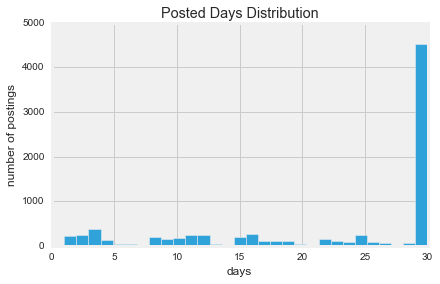

In [34]:
df['post_date'].hist(bins =30)
plt.title('Posted Days Distribution')
plt.xlabel('days')
plt.ylabel('number of postings')

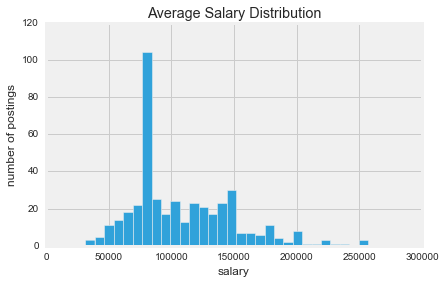

In [39]:
df['salary_avg'].hist(bins =30)
plt.title('Average Salary Distribution')
plt.xlabel('salary')
plt.ylabel('number of postings')

In [38]:
df.salary_avg.value_counts()

77500.0     86
150000.0    21
140000.0    13
76941.5     12
120000.0    10
130000.0     9
100000.0     9
125221.0     9
110000.0     8
200000.0     8
98642.0      7
90000.0      7
180000.0     7
125000.0     7
85000.0      7
145000.0     6
115000.0     6
170000.0     6
64055.5      5
95000.0      5
105000.0     5
105969.5     5
55000.0      5
75000.0      4
88331.0      4
160000.0     4
175000.0     4
65000.0      4
144191.0     3
144731.0     3
            ..
47406.0      1
63864.0      1
31500.0      1
64500.0      1
92524.5      1
81534.0      1
45000.0      1
74119.5      1
55913.0      1
257000.0     1
220000.0     1
89113.0      1
138300.0     1
187500.0     1
122500.0     1
41000.0      1
205150.0     1
47000.0      1
57969.0      1
58025.0      1
74550.0      1
101654.5     1
68739.5      1
42500.0      1
59000.0      1
157500.0     1
86930.5      1
92222.0      1
240000.0     1
90036.0      1
Name: salary_avg, dtype: int64

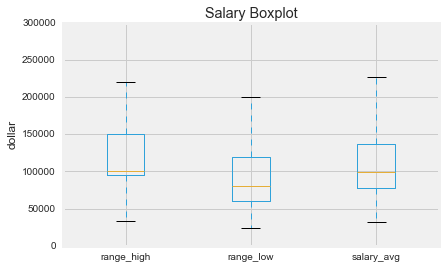

In [418]:
df.ix[:, df.columns.difference(['post_date'])].boxplot()
plt.ylabel('dollar')
plt.title('Salary Boxplot')

In [422]:
temp_state = pd.pivot_table(df, index=['state'], aggfunc = {'salary_avg':(np.mean, 'count'), 'title':'count'}).sort_values(by=('salary_avg','mean'), ascending=False)                                                                                               
temp_state

salary_avg                title
           count           mean count
state                                
VA            31  135082.645161   353
PA            14  128236.392857   693
CA            55  127129.900000  1761
IL            30  125393.333333   619
DE             1  125000.000000   103
MA            40  121564.887500   890
NY           100  110315.290000   884
MD            21  101725.761905   298
DC            37   96134.675676   240
TX            96   75787.640625  1533
IN             0            NaN     2
NJ             0            NaN    11
NV             0            NaN   891

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [3]:
ndf = pd.read_csv('../../../project_data/indeed-scraped-job-postings.csv')
ndf.company.value_counts()

University of Texas at Austin                           2279
Workbridge Associates                                   1146
Emoters Robotics                                         390
Clinical Management Consultants                          389
Analytic Recruiting                                      341
University of Washington Medical Center                   52
DEPT OF HEALTH/MENTAL HYGIENE                             17
All-In Analytics                                          13
University of Washington                                  13
Jobspring Partners                                         7
Selby Jennings                                             7
Smith Hanley Associates                                    6
University of California Berkeley                          5
Averity                                                    5
NJF Search                                                 4
ADMIN FOR CHILDREN'S SVCS                                  4
DEPARTMENT OF FINANCE   

In [4]:
# clean data 
def clean_c(x):
    y = x.replace('+',' ')
    return y
ndf['city'] = ndf['city'].apply(clean_c)

In [5]:
# seperate monthly and yearly salary
ndf.loc[ndf.salary.str.contains('month'), 'salary_type'] = 'month'
ndf.loc[ndf.salary.str.contains('year'), 'salary_type'] = 'year'

In [6]:
# reassign salary column 
ndf['salary'] = ndf['parsed_salary']
ndf = ndf.drop(['parsed_salary'], axis=1)

In [7]:
# Check duplicated data
ndf.duplicated().value_counts()

True     4567
False     224
dtype: int64

In [366]:
# double check duplicated data 
ndf.title.value_counts()

Research Engineering/ Scientist Associate II - Paleontology...     783
Engineering Scientist - Senior Software Defined Radio Receiv...    395
Engineering Scientist Associate - Software Defined Radio Rec...    395
Robotics software engineer (involves machine learning, AI, a...    390
Director of Data Analytics                                         390
Engineering Scientist Associate - Software Engineering Assoc...    389
Manager Health Information Management Data Analysis HIM            389
Senior Java Computer Scientist                                     365
Senior Data Scientist (Healthcare)                                 356
Director of Predictive Analytics (Statistician)                    334
Engineering Scientist - Geospatial Application Software Deve...    301
MEDICAL LABORATORY SCIENTIST-TRAINEE OR 1                           35
Data Scientist                                                      19
Senior Data Scientist                                                8
Progra

In [8]:
# duplicated data seems suspicious, drop!
ndf = ndf.drop_duplicates()

In [9]:
# check numbers of salary left after deleting duplicated data 
ndf.salary_type.value_counts()

year     175
month     48
Name: salary_type, dtype: int64

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [10]:
## YOUR CODE HERE
ndf['salary_v'] = ndf['salary'].map(lambda x: 'high' if x > ndf['salary'].mean() else 'low')

#### Thought experiment: What is the baseline accuracy for this model?

The average salary plays a big role in this model because if the average salary of this sample cannot accurately represent the average of this population, this model cannot accurately predict for the other sets of data. Baseline is going to be the variabl that the model is comparing everything else to, in this case, one of those cities that will be dropped after the dummy variables are created. It also avoids dummy variable trap.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [11]:
# create target variable
ndf['salary_b'] = ndf['salary_v'].map(lambda x: 1 if x == 'high' else 0)

In [12]:
# create dummy variables
dummies = pd.get_dummies(ndf['city'])
ndf

,city,company,salary,summary,title,salary_type,salary_v,salary_b
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,year,high,1
1,San Francisco,Workbridge Associates,155000.0,3+ years of industry experience in a data scie...,Senior Data Scientist,year,high,1
2,San Francisco,Mines.io,100000.0,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,year,high,1
3,San Francisco,Workbridge Associates,165000.0,In this position you will share programming an...,Data Scientist,year,high,1
4,San Francisco,Smith Hanley Associates,140000.0,"This person will recruit, build and lead a tea...",Data Scientist,year,high,1
5,San Francisco,HSF Consulting,300000.0,Teams included Data Services(including data en...,VP of Data Services,year,high,1
6,San Francisco,All-In Analytics,125000.0,Fraud Data Scientist. Seeking someone with ski...,Fraud Data Scientist,year,high,1
7,San Francisco,Brilent,130000.0,"Perform large-scale data analysis, find intere...",Senior Data Scientist,year,high,1
8,San Francisco,HSF Consulting,160000.0,More data- they simply have more data than the...,Senior Data Scientist,year,high,1
10,San Francisco,Jobspring Partners,162500.0,Given the high volume of data collected by the...,Python Developer (Machine Learning),year,high,1


In [13]:
temp = ndf[ndf['salary_type']== 'year']

In [16]:
temp.salary.hist(bins = 50)

In [17]:
# create a new dataframe that contains both target and data
city = pd.concat([ndf['salary_b'], ndf['salary_type'],dummies.iloc[:,1:]], axis=1)

In [29]:
## try to manually add the intercept
# city['intercept'] = 1.0
# city

In [18]:
# seperate year and month - see if it makes a difference
city_y = city[city['salary_type']=='year']
city_m = city[city['salary_type']=='month']

In [19]:
import statsmodels.api as sm
# set data and target, then fit model 
data = city[list(city.columns[2:])]
target = city["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

logit_sm = sm.Logit(y, x)
# fit the model
result_sm = logit_sm.fit()
print result_sm.summary()

Optimization terminated successfully.
         Current function value: 0.624350
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  224
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.09671
Time:                        07:12:06   Log-Likelihood:                -139.85
converged:                       True   LL-Null:                       -154.83
                                        LLR p-value:                 1.417e-06
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.7419      0.384      1.931      0.053        -0.011     1.495
x2            -0.1957      0.

In [20]:
# see what happens to the model if we only do yearly salary
data = city_y[list(city.columns[2:])]
target = city_y["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

logit_sm = sm.Logit(y, x)
# fit the model
result_sm = logit_sm.fit()

print result_sm.summary()

Optimization terminated successfully.
         Current function value: 0.608714
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  175
Model:                          Logit   Df Residuals:                      171
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                 0.09554
Time:                        07:12:14   Log-Likelihood:                -106.52
converged:                       True   LL-Null:                       -117.78
                                        LLR p-value:                 5.123e-05
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.7419      0.384      1.931      0.053        -0.011     1.495
x2            -0.1733      0.

In [21]:
# get AIC and BIC
print result_sm.aic
print result_sm.bic

221.049925031
233.709068927


In [22]:
result_sm.conf_int()

array([[-0.01110481,  1.4949795 ],
       [-0.61045486,  0.26391141],
       [ 0.91378149,  2.79881449],
       [-0.16780176,  1.91873924]])

In [23]:
# get odds ratio 
import numpy as np
print city_y.columns[2:]
print np.exp(result_sm.params)

Index([u'Chicago', u'New York', u'San Francisco', u'Seattle'], dtype='object')
[ 2.1         0.84090909  6.4         2.4       ]


In [24]:
# set different parameters
params = result_sm.params
conf = pd.DataFrame(result_sm.conf_int())
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

       2.5%      97.5%        OR
0  0.988957   4.459245  2.100000
1  0.543104   1.302013  0.840909
2  2.493735  16.425163  6.400000
3  0.845521   6.812364  2.400000


In [25]:
# Marginal Effect 
result_margeff = result_sm.get_margeff()
print result_margeff.summary() 

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1568      0.078      2.020      0.043         0.005     0.309
x2            -0.0366      0.047     -0.783      0.434        -0.128     0.055
x3             0.3922      0.087      4.531      0.000         0.223     0.562
x4             0.1850      0.109      1.697      0.090        -0.029     0.399


In [26]:
city.columns

Index([u'salary_b', u'salary_type', u'Chicago', u'New York', u'San Francisco',
       u'Seattle'],
      dtype='object')

In [36]:
city_y['salary_b_pred'] = result_sm.predict(x)

TypeError: Cannot cast array data from dtype('float64') to dtype('S32') according to the rule 'safe'

In [37]:
city_y.salary_b_pred.value_counts()

0.456790    81
0.864865    37
0.677419    31
0.705882    17
0.500000     9
Name: salary_b_pred, dtype: int64

In [38]:
city.Chicago.value_counts()

0.0    193
1.0     31
Name: Chicago, dtype: int64

In [39]:
city['New York'].value_counts()

0.0    142
1.0     82
Name: New York, dtype: int64

After building a model with logistic regression, we can tell how likely will a city offer higher than average salary. The coefficients (Chicago:0.74, New York: -0.17, San Francisco:1.86, Seattle:0.86) shows whether the salary is going to be high in certain cities compare to Austin. For example, Chicago, Seattle, San Francisco all have higher salaries than the baseline Austin in the yearly salary model, but New York has a lower salary than Austin. The coefficients tell us how that feature is compared to the baseline. However, in order to get the odds, we need to take the exponent of the coefficient. We can also tell from the predicted probability that, Chicago's odd of having a high salary is 67.7%, vs. New York is only 45.7% possible of being high compared to Austin.


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [40]:
ndf

,city,company,salary,summary,title,salary_type,salary_v,salary_b,title_s
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,year,high,1,0
1,San Francisco,Workbridge Associates,155000.0,3+ years of industry experience in a data scie...,Senior Data Scientist,year,high,1,1
2,San Francisco,Mines.io,100000.0,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,year,high,1,0
3,San Francisco,Workbridge Associates,165000.0,In this position you will share programming an...,Data Scientist,year,high,1,0
4,San Francisco,Smith Hanley Associates,140000.0,"This person will recruit, build and lead a tea...",Data Scientist,year,high,1,0
5,San Francisco,HSF Consulting,300000.0,Teams included Data Services(including data en...,VP of Data Services,year,high,1,1
6,San Francisco,All-In Analytics,125000.0,Fraud Data Scientist. Seeking someone with ski...,Fraud Data Scientist,year,high,1,0
7,San Francisco,Brilent,130000.0,"Perform large-scale data analysis, find intere...",Senior Data Scientist,year,high,1,1
8,San Francisco,HSF Consulting,160000.0,More data- they simply have more data than the...,Senior Data Scientist,year,high,1,1
10,San Francisco,Jobspring Partners,162500.0,Given the high volume of data collected by the...,Python Developer (Machine Learning),year,high,1,0


In [41]:
# create dummy for titles that indicates higher level jobs. 
title_s = []
for x in ndf['title']:
    if 'Manager' in x: 
        title_s.append(1)
    elif 'Senior' in x: 
        title_s.append(1)
    elif 'VP' in x: 
        title_s.append(1)
    elif 'Director' in x: 
        title_s.append(1)
    else: 
        title_s.append(0)
ndf['title_s'] = title_s

# ndf['title_s'] = ndf['title'].map(lambda x: 1 if ('Manager' or 'Senior' or 'VP') in x else 0)

# the pre-scrapped dataset seems like there is a lot of duplicates of a few numbers, 
# It's probably becuase the last page is scrapped multiple times (Indeed only shows up to 100 pages of results).  

In [42]:
# add the new dummy column to the dataframe 
city['title_s'] = ndf['title_s']

In [43]:
# create a new dataframe and drop the predicted salary column
city_t = city
city_t = city_t.drop(['salary_b_pred'], axis =1)
city_t

ValueError: labels ['salary_b_pred'] not contained in axis

In [44]:
# build a new model based on it! 
data = city_t[list(city_t.columns[2:])]
target = city_t["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

logit = sm.Logit(y, x)
# fit the model
result = logit.fit()

print result.summary()
print 'AIC: ' + str(result.aic) 
print 'BIC: ' + str(result.bic)

Optimization terminated successfully.
         Current function value: 0.591093
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  224
Model:                          Logit   Df Residuals:                      219
Method:                           MLE   Df Model:                            4
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                  0.1448
Time:                        07:14:27   Log-Likelihood:                -132.40
converged:                       True   LL-Null:                       -154.83
                                        LLR p-value:                 4.283e-09
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3075      0.412      0.747      0.455        -0.499     1.114
x2            -0.5210      0.

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix

In [414]:
data

,Chicago,New York,San Francisco,Seattle
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0
6,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0
10,0.0,0.0,1.0,0.0


In [88]:
logreg = linear_model.LogisticRegression()
result_sk = logreg.fit(x, y)


In [89]:
predictions = result_sk.predict(x)
cm = confusion_matrix(y, predictions)
cm

array([[95, 24],
       [35, 70]])

In [100]:
city_t['proba'] = result_sk.predict_proba(x).T[1]
city_t

,salary_b,salary_type,Chicago,New York,San Francisco,Seattle,title_s,proba
0,1,year,0.0,0.0,1.0,0.0,0,0.712142
1,1,year,0.0,0.0,1.0,0.0,1,0.913733
2,1,year,0.0,0.0,1.0,0.0,0,0.712142
3,1,year,0.0,0.0,1.0,0.0,0,0.712142
4,1,year,0.0,0.0,1.0,0.0,0,0.712142
5,1,year,0.0,0.0,1.0,0.0,1,0.913733
6,1,year,0.0,0.0,1.0,0.0,0,0.712142
7,1,year,0.0,0.0,1.0,0.0,1,0.913733
8,1,year,0.0,0.0,1.0,0.0,1,0.913733
10,1,year,0.0,0.0,1.0,0.0,0,0.712142


In [114]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

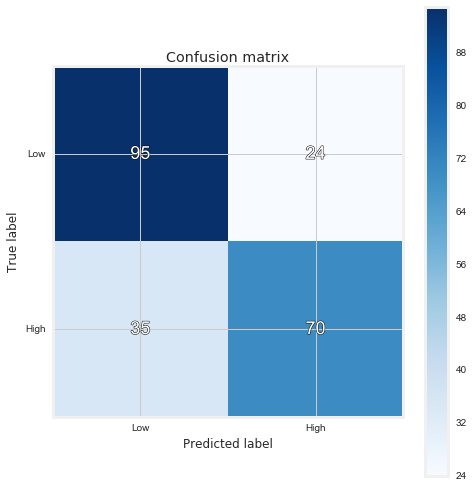

In [115]:
plot_confusion_matrix(cm, title='Confusion matrix', labels=['Low','High'], cmap=plt.cm.Blues)

In [ ]:
# plt.figure(figsize=(10,6))
# ax = plt.subplot(111)

# for e, c in enumerate(city_t):
#     city_t[city_t[days[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', label = names[e], color = c, ax=ax)

# ax.legend(loc='upper left')
# ax.set_title('Probability of Delay\n Based on Day of Week and Time of Day')
# ax.set_xlabel('Scheduled departure time (2400 clock)')

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [116]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

print 'Accuracy_score: ' + str(accuracy_score(y, predictions))
print 'Precision_score: ' + str(precision_score(y, predictions))
print 'Recall_score: ' + str(recall_score(y, predictions))

Accuracy_score: 0.736607142857
Precision_score: 0.744680851064
Recall_score: 0.666666666667


In [117]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

roc = roc_curve(y, city_t.proba)
roc

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title)
    plt.legend(loc='best')

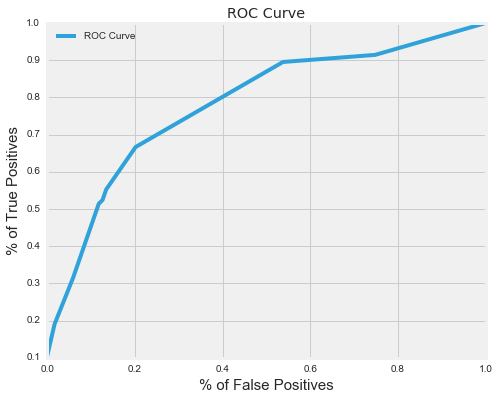

In [118]:
getROCcurve(roc)

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [119]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score

lr_l1 = LogisticRegression(C=1.5, penalty='l1', solver='liblinear')
lr_l1_model = lr_l1.fit(x, y)
lr_l1_ypred = lr_l1_model.predict(x)

    0   1
0  95  24
1  35  70


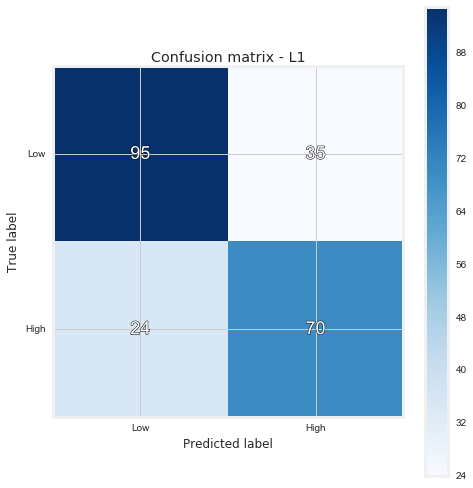

In [128]:
cm1 = confusion_matrix(y, lr_l1_ypred, labels=lr_l1.classes_)
cm1 = pd.DataFrame(lr_l1_cm, columns=lr_l1.classes_, index=lr_l1.classes_)
print cm1
plot_confusion_matrix(cm1, title='Confusion matrix - L1', labels=['Low','High'], cmap=plt.cm.Blues)

In [108]:
cross_val_score(lr_l1, x, y, cv=3).mean()

0.28678678678678676

    0   1
0  95  24
1  35  70


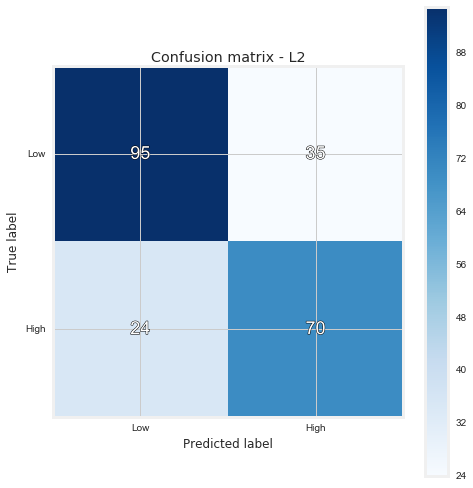

In [129]:
lr2 = LogisticRegression(penalty='l2')
lr2_model = lr2.fit(x, y)
vice_y2_pred = lr2.predict(x)
cm2 = confusion_matrix(y, vice_y2_pred, labels=lr2.classes_)
cm2 = pd.DataFrame(cm2, columns=lr2.classes_, index=lr2.classes_)
print cm2
plot_confusion_matrix(cm2, title='Confusion matrix - L2', labels=['Low','High'], cmap=plt.cm.Blues)

In [110]:
## YOUR CODE HERE
logreg = linear_model.LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(x, y)
gs.best_params_

{'C': 0.15, 'penalty': 'l1'}

## Predict Scrapped Data 

In [134]:
import pandas as pd
df = pd.read_csv('final_df.csv')

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8283 entries, 0 to 8282
Data columns (total 16 columns):
Unnamed: 0        8283 non-null int64
company           8283 non-null object
description       8283 non-null object
location          8283 non-null object
post_date         8283 non-null int64
salary            8283 non-null object
title             8283 non-null object
temp              8283 non-null object
city              8283 non-null object
temp1             8283 non-null object
state             8278 non-null object
yearly_salary     425 non-null object
monthly_salary    354 non-null object
range_low         425 non-null float64
range_high        328 non-null float64
salary_avg        425 non-null float64
dtypes: float64(3), int64(2), object(11)
memory usage: 1.0+ MB


In [136]:
## YOUR CODE HERE
df['salary_v'] = df['salary_avg'].map(lambda x: 'high' if x > df['salary_avg'].mean() else 'low')
# create target variable
df['salary_b'] = df['salary_v'].map(lambda x: 1 if x == 'high' else 0)

In [137]:
df.state.value_counts()

CA    1761
TX    1533
NV     891
MA     890
NY     884
PA     693
IL     619
VA     353
MD     298
DC     240
DE     103
NJ      11
IN       2
Name: state, dtype: int64

In [138]:
# create dummy variables
dummies = pd.get_dummies(df['state'])
dummies

,CA,DC,DE,IL,IN,MA,MD,NJ,NV,NY,PA,TX,VA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [139]:
# create a new dataframe that contains both target and data
subset = pd.concat([df['salary_b'],dummies.iloc[:,1:]], axis=1)
subset

,salary_b,DC,DE,IL,IN,MA,MD,NJ,NV,NY,PA,TX,VA
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [140]:
import statsmodels.api as sm
# set data and target, then fit model 
data = subset[list(subset.columns[1:])]
target = subset["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

In [141]:
logit_sm = sm.Logit(y, x)
# fit the model
result_sm = logit_sm.fit()
print result_sm.summary()

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [131]:
# get AIC and BIC
print result_sm.aic
print result_sm.bic

274.809642288
291.867872547


#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE

In [ ]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [ ]:
## YOUR CODE HERE